In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from keras import backend as K
import keras
import os

import pandas as pd
import numpy as np

import seaborn as sns
from pylab import rcParams

import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
# %config InlineBackend.figure_format='retina'

from keras.layers import Lambda, Input, Dense, Flatten
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model

import argparse
import scipy

# 查看可用的 GPU 

print(K.tensorflow_backend._get_available_gpus())
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
# set random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.set_random_seed(RANDOM_SEED)

In [3]:
# Loading Data
bearing_data = pd.read_csv('/home/cslab/Desktop/Anomaly_detection/Fault_prediction/Preprocessing/merged_dataset_rms_BearingTest_2.csv', header=0, index_col=0)

# 分割 Train/Test Data
bearing_train = bearing_data['2004-02-12 11:02:39':'2004-02-15 12:52:39']
bearing_test = bearing_data['2004-02-15 12:52:39':]

In [4]:
print(bearing_train.shape)
print(bearing_test.shape)

(444, 4)
(538, 4)


In [11]:
# Normalize the data
# Function to scale the data
from sklearn import preprocessing

def data_Normalize(bearing_train, bearing_test):
    scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
    X_train = scaler.fit_transform(bearing_train)
    X_test = scaler.transform(bearing_test)
    return X_train, X_test

X_train, X_test = data_Normalize(bearing_train, bearing_test)

NameError: name 'bearing_train' is not defined

In [6]:
print(X_train.shape)
print(X_test.shape)

(444, 4)
(538, 4)


<function matplotlib.pyplot.show(*args, **kw)>

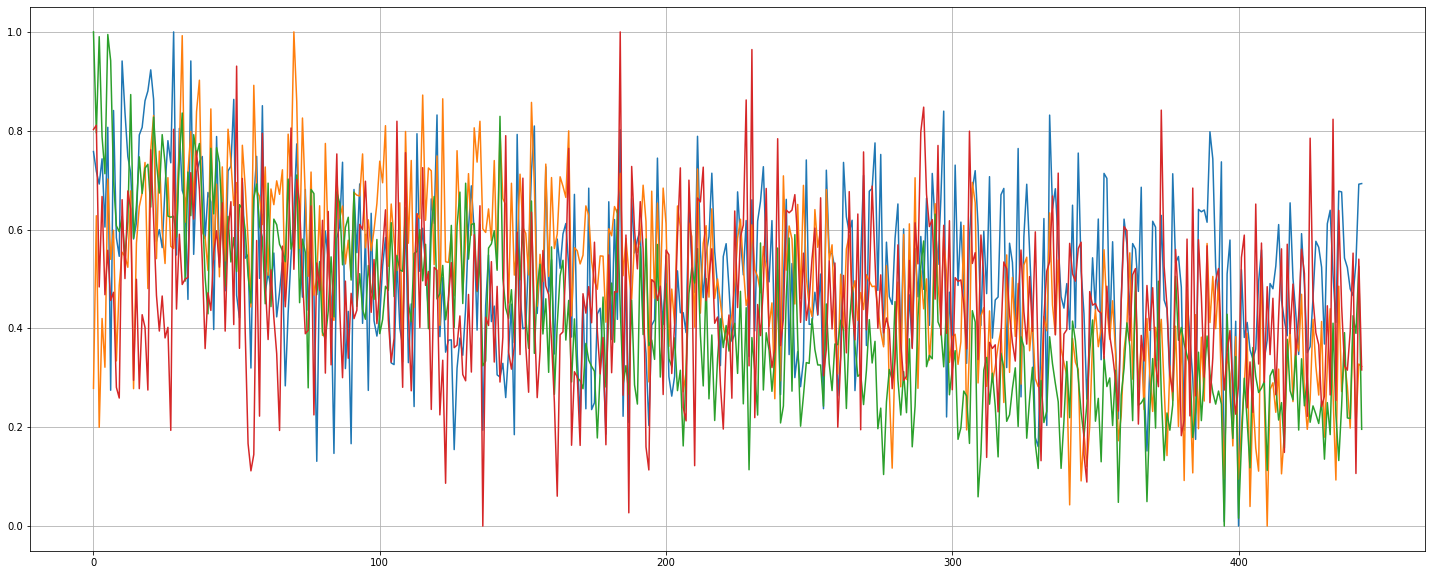

In [7]:
#visialisation
plt.figure(figsize=(25, 10))
plt.plot(X_train)
plt.grid()
plt.show

In [8]:
# Network parameters
original_dim = X_train.shape[1] # 原始輸入維度
input_shape = (original_dim, )
# time_window_size = rate
# intermediate_dim = 20 # 神經元個數 中間隱藏層的維度
latent_dim = 2 # 編碼後的code的維度
BATCH_SIZE = 128
NUM_EPOCHS = 500

In [9]:
# sampling function
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
# 使用均值變數（mean vector）和標準差變數（standard deviation vector）合成隱變數
def sampling(args):
    """
    Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [10]:
# VAE model = encoder + decoder
## Build Encoder model

# inputs = Input(shape=(time_window_size, ), name='encoder_input')
inputs = Input(shape=input_shape, name='encoder_input')

# x = Dense(intermediate_dim, activation='relu')(inputs)
x = Dense(128, activation='relu')(inputs)
x = keras.layers.Dropout(0.1)(x)
x = Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.1)(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)

# shape info needed to build decoder model
# shape = K.int_shape(x)

# generate latent vector Q(z|X)
# x = Flatten(name='encoder_flat')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
# sample vector from the latent distribution
# z即為所要求得的隱含變數
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
variational_encoder = Model(inputs=inputs, outputs=[z_mean, z_log_var, z], name='variational_encoder')
variational_encoder.summary()

# plot encoder model
# plot_model(variational_encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

## Build Decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
# x = Dense(intermediate_dim, activation='relu')(latent_inputs)
x = Dense(16, activation='relu')(latent_inputs)
x = Dense(32, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(128, activation='relu')(x)

# outputs = Dense(original_dim, activation='sigmoid')(x)
outputs = Dense(original_dim, activation='tanh')(x)

# instantiate decoder model
variational_decoder = Model(inputs=latent_inputs, outputs=outputs, name='variational_decoder')
variational_decoder.summary()

# plot decoder model
# plot_model(variational_decoder, to_file='vae_mlp_decoder.png', show_shapes=True)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 4)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          640         encoder_input[0][0]              
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128)          0           dense_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

In [11]:
from keras import losses

In [12]:
# Instantiate VAE model
reconstructions_outputs = variational_decoder(variational_encoder(inputs)[2])
# _, _, outputs = variational_encoder(inputs) 經variational_encoder運算後取輸出[2] 再放入variational_decoder做輸入得到重建 model
vae_model = Model(inputs=inputs, outputs=reconstructions_outputs, name='vae_reconstructions_model')
vae_model.summary()

# VAE loss = mse_loss or xent_loss + kl_loss
# def vae_loss(inputs, outputs):
#     reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))

#     reconstruction_loss *= time_window_size

#     kl_loss = -0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
#     vae_loss = K.mean(reconstruction_loss + kl_loss)
#     return vae_loss
    
def vae_loss(inputs, outputs):
    reconstruction_loss = losses.binary_crossentropy(inputs, outputs)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return reconstruction_loss + kl_loss
    
#vae.add_loss(vae_loss)   
vae_model.compile(optimizer='RMSprop',loss=vae_loss)
# vae_model.compile(loss='mse',optimizer=keras.optimizers.Adam(lr=0.0001))

# plot vae model 
# plot_model(vae_model, to_file='vae_mlp.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 4)                 0         
_________________________________________________________________
variational_encoder (Model)  [(None, 2), (None, 2), (N 11572     
_________________________________________________________________
variational_decoder (Model)  (None, 4)                 11540     
Total params: 23,112
Trainable params: 23,112
Non-trainable params: 0
_________________________________________________________________


In [13]:
filepath="vae_best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True,mode='min')
callbacks_list = [checkpoint]
# vae.fit(np.expand_dims(training,axis=-1),target,epochs=epochs,batch_size=batch_size,callbacks=callbacks_list)


results=vae_model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE,
                  shuffle=True,
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 1,
                  callbacks=callbacks_list
                  )

Train on 421 samples, validate on 23 samples
Epoch 1/500
421/421 [==============================] - 2s 6ms/step - loss: 5.1726 - val_loss: 2.6879

Epoch 00001: loss improved from inf to 5.17259, saving model to vae_best.h5
Epoch 2/500
421/421 [==============================] - 0s 60us/step - loss: 2.7673 - val_loss: 2.6550

Epoch 00002: loss improved from 5.17259 to 2.76735, saving model to vae_best.h5
Epoch 3/500
421/421 [==============================] - 0s 62us/step - loss: 2.6958 - val_loss: 2.6246

Epoch 00003: loss improved from 2.76735 to 2.69576, saving model to vae_best.h5
Epoch 4/500
421/421 [==============================] - 0s 65us/step - loss: 2.6602 - val_loss: 2.6123

Epoch 00004: loss improved from 2.69576 to 2.66021, saving model to vae_best.h5
Epoch 5/500
421/421 [==============================] - 0s 73us/step - loss: 2.6307 - val_loss: 2.6309

Epoch 00005: loss improved from 2.66021 to 2.63071, saving model to vae_best.h5
Epoch 6/500
421/421 [========================

In [29]:
# print(vae_model.get_weights())

In [14]:
# Obtaining the X_train predictions
# batch_size = BATCH_SIZE
X_train_pred = vae_model.predict(X_train)
X_train_pred = pd.DataFrame(X_train_pred,
                      columns=bearing_train.columns)
X_train_pred.index = bearing_train.index

scored_train = pd.DataFrame(index=bearing_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_train_pred-X_train), axis = 1)

# Obtaining the X_test predictions
X_test_pred = vae_model.predict(X_test)
X_test_pred = pd.DataFrame(X_test_pred, 
                      columns=bearing_test.columns)
X_test_pred.index = bearing_test.index

scored_test = pd.DataFrame(index=bearing_test.index)
scored_test['Loss_mae'] = np.mean(np.abs(X_test_pred-X_test), axis = 1)

# and merge all data in a single dataframe
scored = pd.concat([scored_train, scored_test])

In [34]:
scored.to_csv('scored.csv')

### 階段二

In [201]:
scored = pd.read_csv('/home/cslab/Desktop/Anomaly_detection/Fault_prediction/scored.csv', header=0, index_col=0)

In [202]:
scored.head()

,Loss_mae
2004-02-12 11:02:39,0.352789
2004-02-12 11:12:39,0.261593
2004-02-12 11:22:39,0.266432
2004-02-12 11:32:39,0.222856
2004-02-12 11:42:39,0.141908


In [203]:
scored.shape

(982, 1)

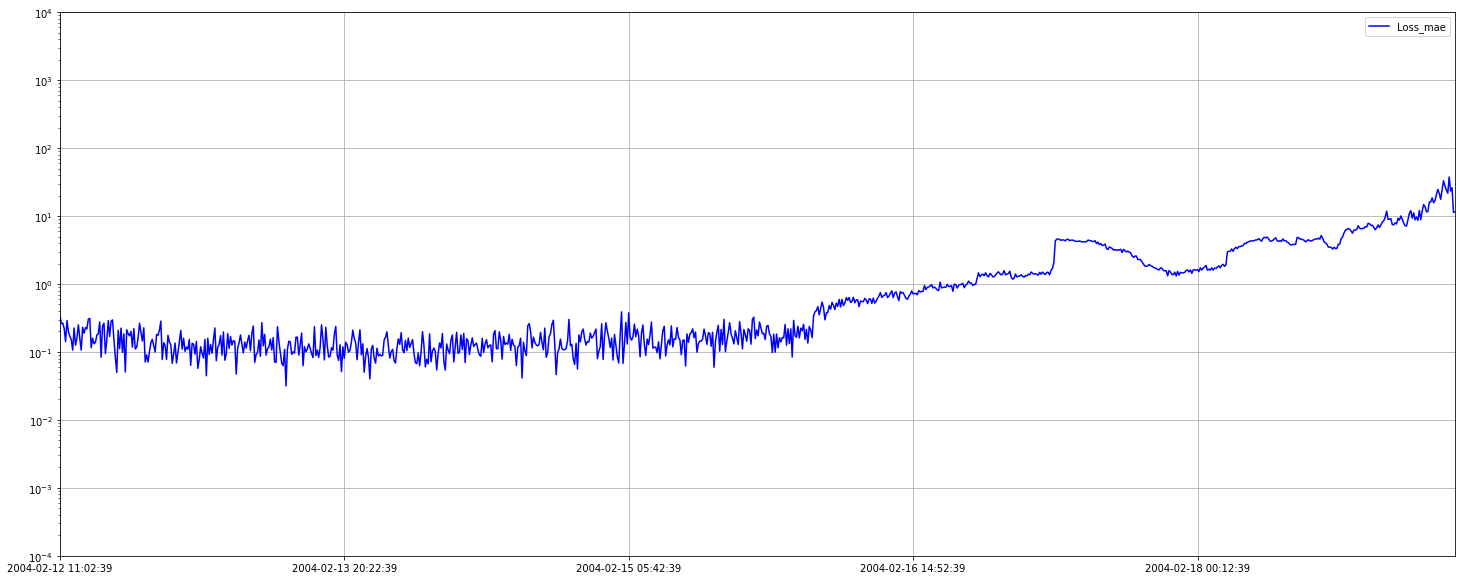

In [204]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize = (25, 10), ylim = [1e-4,1e4], grid=True, color = 'blue')

In [205]:
# 因須評估耗損時間起始點，先依據先前分割 Train/Test 方式分割
scaler_train = scored['2004-02-12 11:02:39':'2004-02-15 12:52:39']
scaler_test = scored['2004-02-15 12:52:39':]

print(scaler_train.shape)
print(scaler_test.shape)

(445, 1)
(539, 1)


(0.0, 0.5)

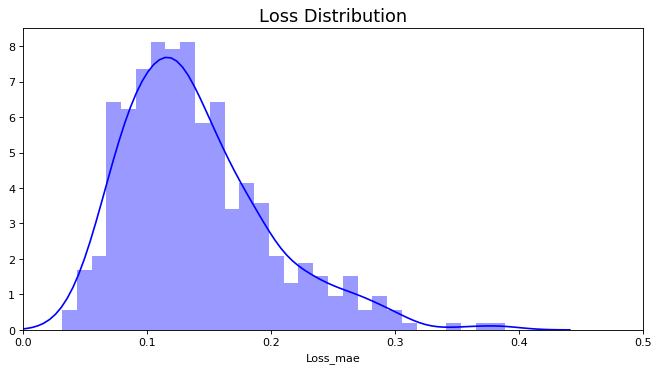

In [15]:
# 損耗評估起始時間
plt.figure(figsize=(10, 5), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scaler_train['Loss_mae'],
             bins = 30, 
             kde= True,
            color = 'blue');
plt.xlim([0.0,.5])

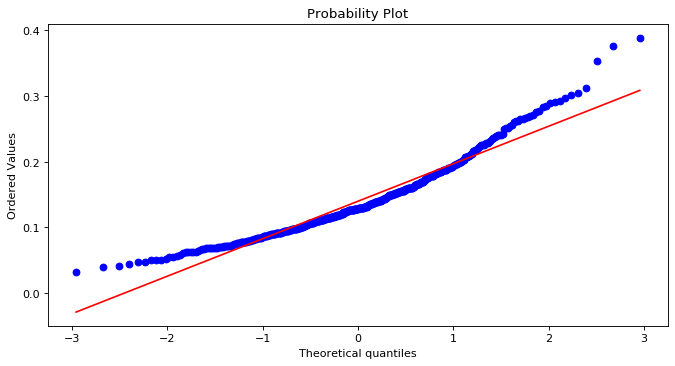

In [14]:
# 查看是否擬合正態分佈(使用 QQ plot)
from scipy import stats

plt.figure(figsize=(10, 5), dpi=80)

stats.probplot(scaler_train['Loss_mae'], dist="norm", plot=plt)
plt.show()

Skewness of saleprice: 1.0453577981158766
Kurtosis of saleprice: 1.3485969337996448


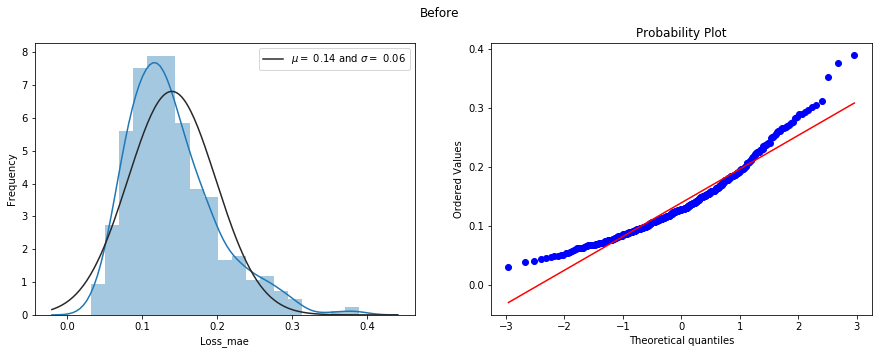

In [20]:
from scipy import stats
from scipy.stats import norm, skew
# 查看 scaler_train['Loss_mae'] 的 skewness
fig=plt.figure(figsize=(15,5))
# pic1
plt.subplot(1,2,1)
sns.distplot(scaler_train['Loss_mae'],fit=norm)
(mu,sigma)=norm.fit(scaler_train['Loss_mae'])
plt.legend(['$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu,sigma)],loc='best')
plt.ylabel('Frequency')
# pic2
plt.subplot(1,2,2)
res=stats.probplot(scaler_train['Loss_mae'],plot=plt)
plt.suptitle('Before')
print(f"Skewness of saleprice: {scaler_train['Loss_mae'].skew()}")
print(f"Kurtosis of saleprice: {scaler_train['Loss_mae'].kurt()}")

In [27]:
scaler_train['Box-cox'] = scaler_train['Loss_mae']

In [36]:
scaler_train.head()

,Loss_mae,Box-cox
2004-02-12 11:02:39,0.352789,0.352789
2004-02-12 11:12:39,0.261593,0.261593
2004-02-12 11:22:39,0.266432,0.266432
2004-02-12 11:32:39,0.222856,0.222856
2004-02-12 11:42:39,0.141908,0.141908


In [39]:
# 當原始數據分佈是有偏度時，不滿足正態分佈，通過Box-cox轉換修正分佈的偏態
# 使用 Box-cox 來降低 skewness 值，達到接近正態分佈的目的
# power transform
from scipy.stats import boxcox

# 需搜尋最優的參數 lambda
scaler_train['Box-cox'],lambda_=stats.boxcox(scaler_train['Box-cox'])
print(f"λ : {lambda_}")

λ : 0.10305715244213466


Skewness of saleprice: -0.0008562920012883532
Kurtosis of saleprice: -0.05424116740692009


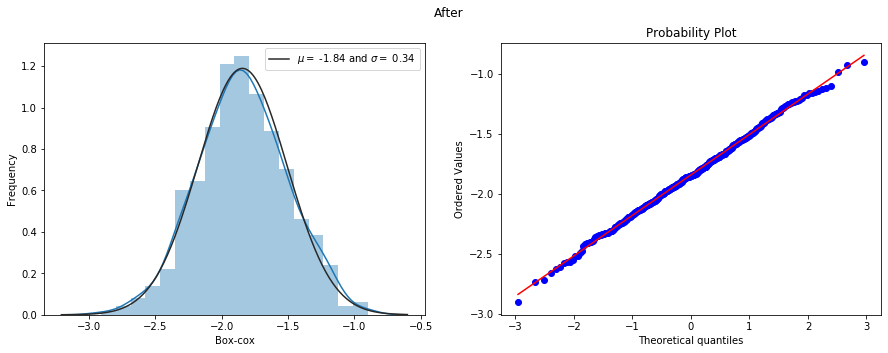

In [40]:
fig=plt.figure(figsize=(15,5))
#pic1
plt.subplot(1,2,1)
sns.distplot(scaler_train['Box-cox'],fit=norm)
(mu,sigma)=norm.fit(scaler_train['Box-cox'])
plt.legend(['$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu,sigma)],loc='best')
plt.ylabel('Frequency')
#pic2
plt.subplot(1,2,2)
res=stats.probplot(scaler_train['Box-cox'],plot=plt)
plt.suptitle('After')
print(f"Skewness of saleprice: {scaler_train['Box-cox'].skew()}")
print(f"Kurtosis of saleprice: {scaler_train['Box-cox'].kurt()}")

In [44]:
scaler_train['invert_Box-cox'] = scaler_train['Box-cox']

In [45]:
scaler_train.head()

,Loss_mae,Box-cox,invert_Box-cox
2004-02-12 11:02:39,0.352789,-0.987898,-0.987898
2004-02-12 11:12:39,0.261593,-1.252433,-1.252433
2004-02-12 11:22:39,0.266432,-1.236455,-1.236455
2004-02-12 11:32:39,0.222856,-1.390864,-1.390864
2004-02-12 11:42:39,0.141908,-1.768660,-1.768660


In [58]:
# 暫不用
# invert a boxcox transform for one value
from math import log
from math import exp

def invert_boxcox(value, lam):
    # log case
    if lam == 0:
        return np.exp(value)
    # all other cases
    return exp(np.log(lam * value + 1) / lam)

# invert transform
scaler_train['invert_Box-cox'] = [invert_boxcox(x, lambda_) for x in scaler_train['invert_Box-cox']]

In [72]:
def threshold_select(value, lam):
    # log case
    if lam == 0:
        return np.exp(np.mean(value) + np.std(value)*3)
    # all other cases
    return (lam*(np.mean(value) + np.std(value)*3)+1)**(1/lam)

In [79]:
threshold_boxcox = threshold_select(scaler_train['Box-cox'], lambda_)

## 模擬測試

In [196]:
# test
RANDOM_SEED = 42

# set random seed
np.random.seed(RANDOM_SEED)
tf.set_random_seed(RANDOM_SEED)

time = np.arange(0, 200, 0.1)
# sin = np.sin(time)
sin = np.sin(time)+ np.random.normal(scale=0.5, size=len(time))

df_sine = pd.DataFrame(dict(sine=sin), index=time, columns=['sine'])
df_sine.reset_index(drop=True, inplace = True)
df_sine.rename(columns={"sine": "sine wave"}, inplace = True)

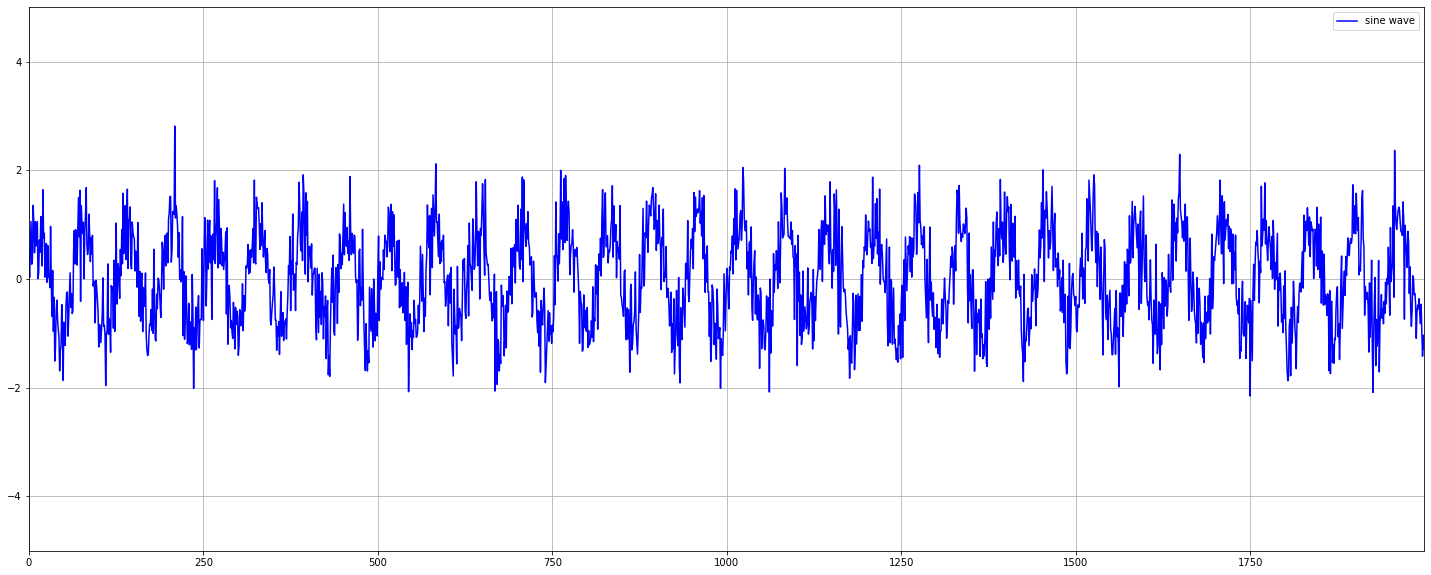

In [197]:
df_sine.plot(figsize = (25, 10), grid=True, ylim = [-5, 5], color = 'blue')

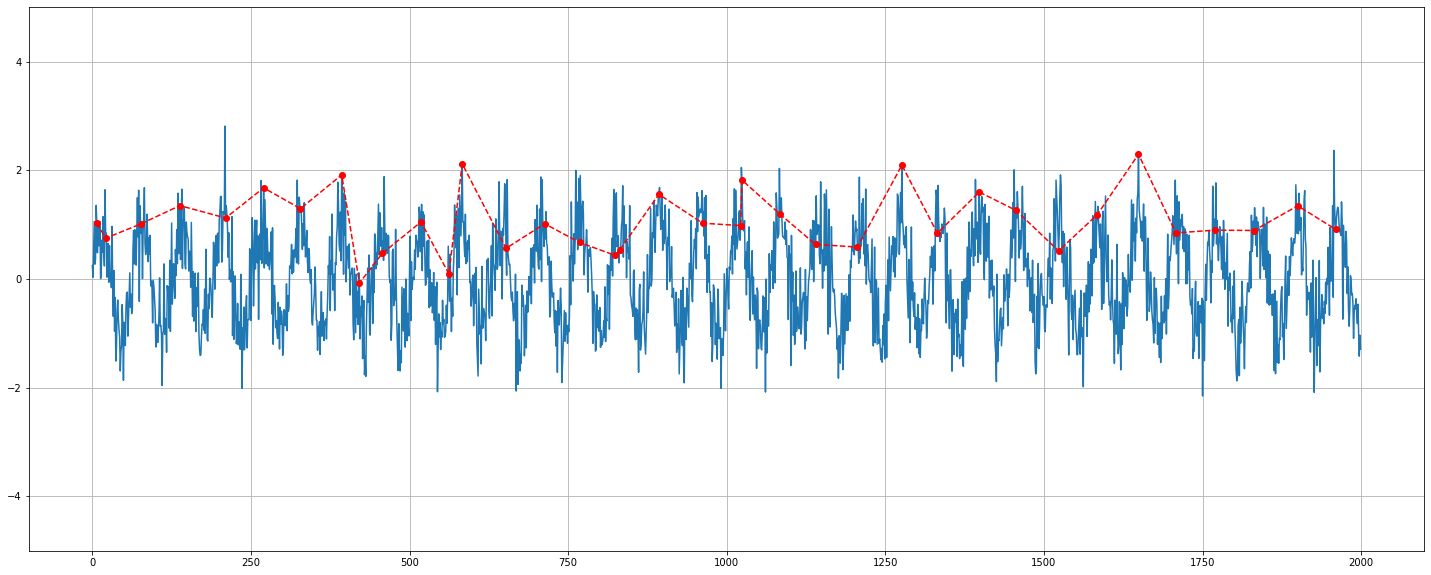

In [200]:
from scipy import signal

time_series = df_sine['sine wave'].values

# Find peaks(max)
widths=np.arange(1,25)
peak_indexes = signal.find_peaks_cwt(time_series, widths)


plt.figure(figsize=(25, 10))
plt.plot(time_series)

# Plot peaks
peak_x = peak_indexes
peak_y = time_series[peak_indexes]
plt.plot(peak_x, peak_y, marker='o', linestyle='dashed', color='red', label="Peaks")
plt.ylim(-5, 5)
plt.grid(True)
plt.show()

In [ ]:
# 觸發異常預測(TSP 觸發)
def TSP_trigger(data, peak_indexes, threshold):
    for x in peak_indexes:
        

In [80]:
threshold_boxcox

0.41681657855519105

In [81]:
scored['Threshold-boxcox'] = threshold_boxcox

In [85]:
scored.head()

,Loss_mae,Threshold-boxcox,Threshold
2004-02-12 11:02:39,0.352789,0.416817,0.387968
2004-02-12 11:12:39,0.261593,0.416817,0.387968
2004-02-12 11:22:39,0.266432,0.416817,0.387968
2004-02-12 11:32:39,0.222856,0.416817,0.387968
2004-02-12 11:42:39,0.141908,0.416817,0.387968


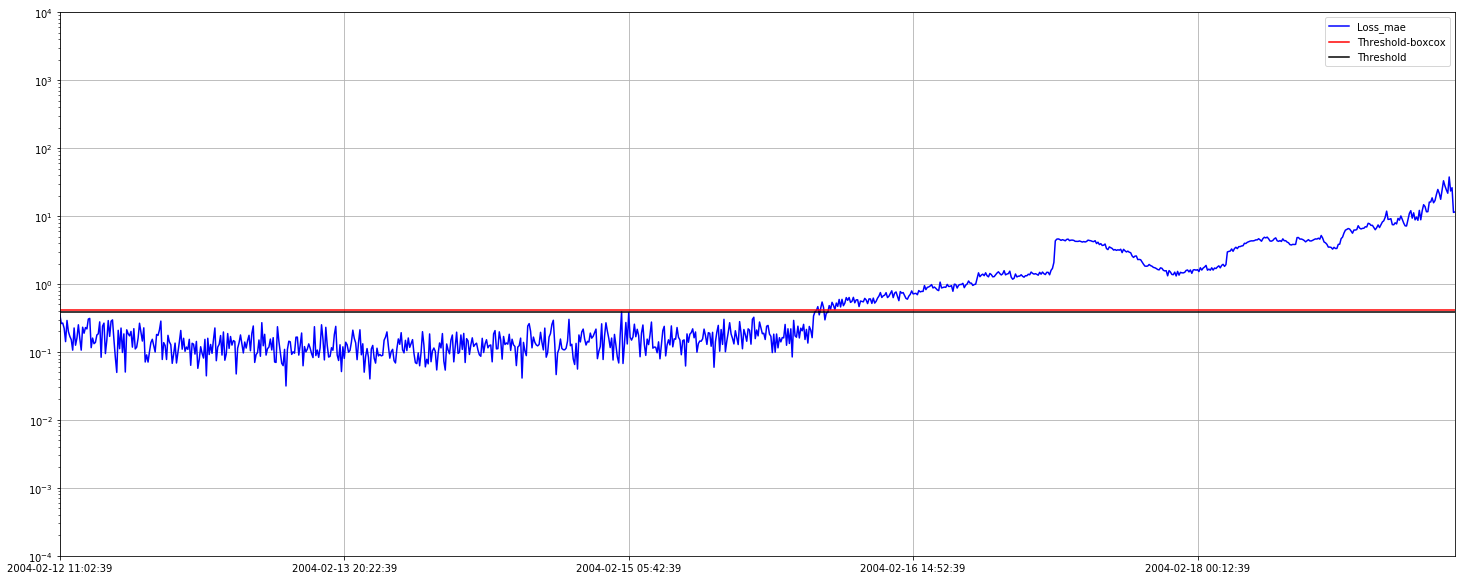

In [87]:
scored.plot(logy=True,  figsize = (25, 10), ylim = [1e-4,1e4], grid=True, color = ['blue', 'red', 'black'])

In [83]:
# Threshold 決定(評估耗損時間起始點 TSP)
# 將 Threshold 設定為高於數據 99.98%
TSP_threshold = np.quantile(scaler_train['Loss_mae'], q=0.9998)
print(f'MSE 0.9998 Threshold: {TSP_threshold}')
print(max(scaler_train['Loss_mae']))

MSE 0.9998 Threshold: 0.38796780785527
0.3890750926101037


In [84]:
scored['Threshold'] = TSP_threshold

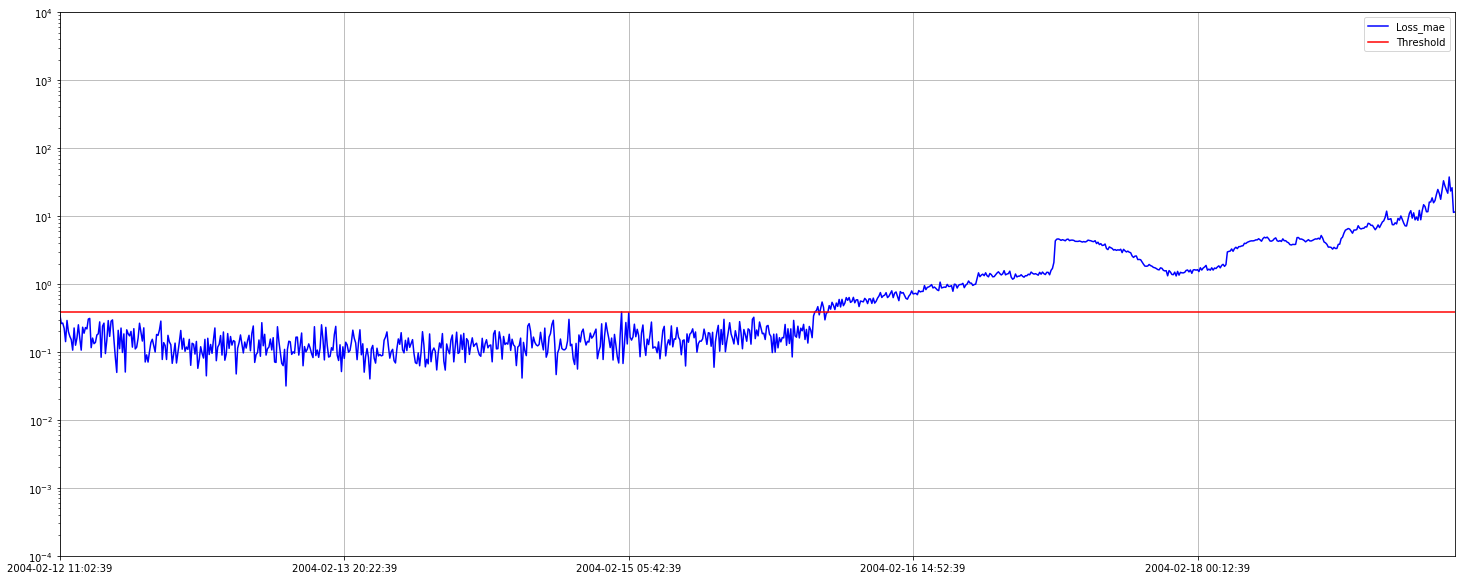

In [27]:
scored.plot(logy=True,  figsize = (25, 10), ylim = [1e-4,1e4], grid=True, color = ['blue', 'red'])

In [8]:
# normalize the dataset
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scored_MinMax = scaler.fit_transform(scored)
print(scored_MinMax.shape)

(982, 1)


In [9]:
# moving average algorithm (MA)
scored_MinMax_frame = pd.DataFrame(scored_MinMax,
                                  columns=scored.columns)
scored_MinMax_frame.index = scored.index

scored_dataset_rolling_mean5 = scored_MinMax_frame.rolling(window=5).mean()
scored_dataset_rolling_mean10 = scored_MinMax_frame.rolling(window=10).mean()
scored_dataset_rolling_mean20 = scored_MinMax_frame.rolling(window=20).mean()

print(scored_dataset_rolling_mean5.shape)
print(scored_dataset_rolling_mean10.shape)
print(scored_dataset_rolling_mean20.shape)

# print(scored_dataset.shape)
# scored_dataset.plot(logy=True,  figsize = (25, 10), ylim = [1e-3,1e3], grid=True, color = 'blue')

(982, 1)
(982, 1)
(982, 1)


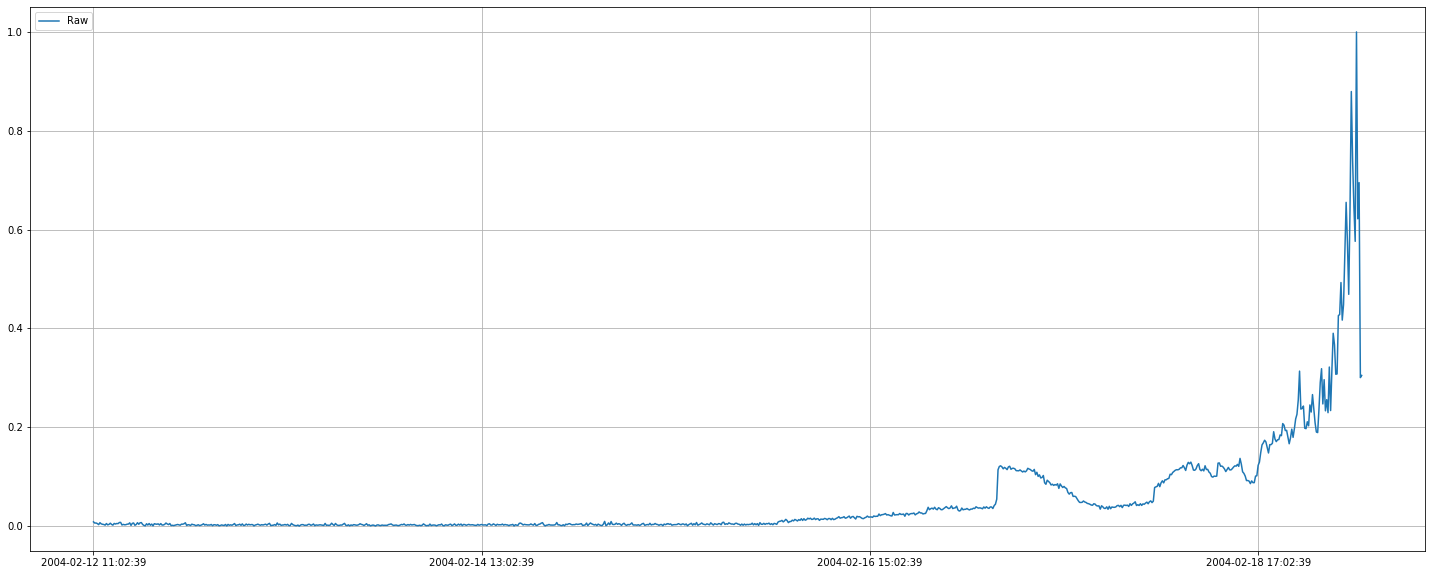

In [11]:
fig, axes = plt.subplots(figsize=(25, 10))
axes.plot(scored_MinMax_frame, label='Raw')
axes.xaxis.set_major_locator(ticker.MaxNLocator(4))
axes.legend(loc='upper left')
plt.grid(True)
plt.show()

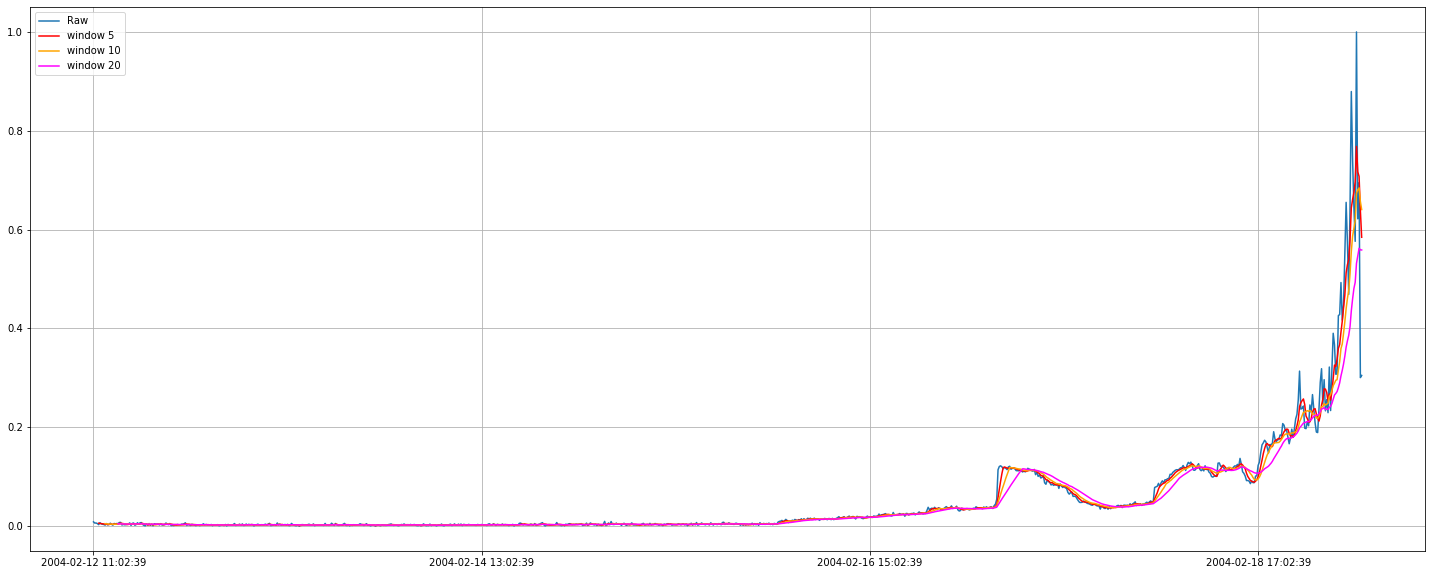

In [10]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(figsize=(25, 10))
axes.plot(scored_MinMax_frame, label='Raw')
axes.plot(scored_dataset_rolling_mean5, label='window 5', color='red')
axes.plot(scored_dataset_rolling_mean10, label='window 10', color='orange')
axes.plot(scored_dataset_rolling_mean20, label='window 20', color='magenta')
axes.xaxis.set_major_locator(ticker.MaxNLocator(4))
axes.legend(loc='upper left')
plt.grid(True)
plt.show()

In [12]:
# split into train and test sets
# train_size = int(len(dataset) * 0.7)
# test_size = len(dataset) - train_size
# train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

train = scored_dataset_rolling_mean10['2004-02-12 11:02:39':'2004-02-15 12:52:39']
test = scored_dataset_rolling_mean10['2004-02-15 12:52:39':]

In [13]:
print(train.shape)
print(test.shape)

(445, 1)
(539, 1)


In [21]:
a = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
b = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [31]:
look_back = 1
ax = timeseries_to_supervised(a)

In [41]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [40]:
look_back = 1
trainX, trainY = create_dataset(a, look_back)

IndexError: too many indices for array

In [42]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

TypeError: '(slice(0, 1, None), 0)' is an invalid key

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))